# Loading Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(12, 5)},
        font_scale=1.5,
        style="whitegrid")
        
from pyspark.sql import HiveContext
from pyspark.sql import SQLContext

# initialize session hive and sql environments
hiveContext = HiveContext(sc)
sqlContext = SQLContext(sc)

# Data Reading

In [3]:
project_folder = "../"
datapath = project_folder + "data/"
plotpath = project_folder + "graphs/"
mungepath = project_folder + "munge/"
configpath = project_folder + "config/"
diagnostic = project_folder + "diagnostic/"
modelpath = project_folder + "model/"
output = project_folder + "output/"

In [4]:
from pyspark.sql.functions import col

train = spark.read.csv(os.path.join(datapath,"train.csv"), header=True)
print('Found %d observations in training set.' %train.count())

Found 184903890 observations in training set.


In [5]:
from pyspark.sql.functions import col

test_old = (spark.read.csv(os.path.join(datapath,"test_supplement.csv"), header=True)
            .filter(col('click_time') >= '2017-11-09 16:00:00'))

print('Found %d observations in test_old set.' %test_old.count())

Found 57536872 observations in test_old set.


In [6]:
train.show(10)

+------+---+------+---+-------+-------------------+---------------+-------------+
|    ip|app|device| os|channel|         click_time|attributed_time|is_attributed|
+------+---+------+---+-------+-------------------+---------------+-------------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21|           null|            0|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34|           null|            0|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12|           null|            0|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52|           null|            0|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08|           null|            0|
| 18787|  3|     1| 16|    379|2017-11-06 14:36:26|           null|            0|
|103022|  3|     1| 23|    379|2017-11-06 14:37:44|           null|            0|
|114221|  3|     1| 19|    379|2017-11-06 14:37:59|           null|            0|
|165970|  3|     1| 13|    379|2017-11-06 14:38:10|           null|            0|
| 74544| 64|    

In [7]:
train.printSchema()

root
 |-- ip: string (nullable = true)
 |-- app: string (nullable = true)
 |-- device: string (nullable = true)
 |-- os: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- click_time: string (nullable = true)
 |-- attributed_time: string (nullable = true)
 |-- is_attributed: string (nullable = true)



# Build the full dataset

In [8]:
# train and test set concatenation
from pyspark.sql.functions import col
data = (train.select('ip', 'app', 'device', 'os', 'channel', 'click_time')
        .unionAll(test_old.select('ip', 'app', 'device', 'os', 'channel', 'click_time')))
        
print('Total number of clicks in one week:', data.count())

Total number of clicks in one week: 242440762


In [9]:
data.show(5)

+------+---+------+---+-------+-------------------+
|    ip|app|device| os|channel|         click_time|
+------+---+------+---+-------+-------------------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08|
+------+---+------+---+-------+-------------------+
only showing top 5 rows



# Datetime Features

In [10]:
# day function
def get_day(date):
    """
    Returns the hour based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        day: A String containing the day of click ("06", "07", .."10")
    """
    
    return date[8:10]

# hour function
def get_hour(date):
    """
    Returns the hour based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        hour: A String containing the hour interval ("01", "02", .."23")
    """
    
    return date[11:13]

# minute function
def get_minute(date):
    """
    Returns the minute based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        hour: A String containing the minute interval ("01", "02", .."59")
    """
    
    return date[14:16]

# second function
def get_second(date):
    """
    Returns the second based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        hour: A String containing the minute interval ("01", "02", .."59")
    """
    
    return date[17:19]

In [11]:
# Get datetime features
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

day_udf = udf(get_day, StringType())
hour_udf = udf(get_hour, StringType())
minute_udf = udf(get_minute, StringType())
second_udf = udf(get_second, StringType())

data = data.withColumn('day', day_udf(data.click_time))
data = data.withColumn('hour', hour_udf(data.click_time))
data = data.withColumn('minute', minute_udf(data.click_time))
data = data.withColumn('second', second_udf(data.click_time))

In [12]:
data.show(5)

+------+---+------+---+-------+-------------------+---+----+------+------+
|    ip|app|device| os|channel|         click_time|day|hour|minute|second|
+------+---+------+---+-------+-------------------+---+----+------+------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21| 06|  14|    32|    21|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34| 06|  14|    33|    34|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12| 06|  14|    34|    12|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52| 06|  14|    34|    52|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08| 06|  14|    35|    08|
+------+---+------+---+-------+-------------------+---+----+------+------+
only showing top 5 rows



# IP Number of Clicks for same Os in same Minute

In [13]:
from pyspark.sql.functions import col, unix_timestamp, lit
import pyspark.sql.functions as func

In [14]:
var = 'os'

In [15]:
ip_var_minute_clicks = (data
                        .groupBy('ip', var, 'day', 'hour', 'minute')
                        .agg(func.count(func.lit(1)).alias('ip_'+var+'_minute_clicks'),
                             func.round(func.stddev(col('second')), 2).alias('ip_'+var+'_minute_std_second'),
                             func.round(func.mean(col('second')), 2).alias('ip_'+var+'_minute_avg_second'))
                        .fillna({'ip_'+var+'_minute_std_second':0,
                               'ip_'+var+'_minute_avg_second':0})
                      .cache())

ip_var_minute_clicks.show(100, truncate=False)

+------+---+---+----+------+-------------------+-----------------------+-----------------------+
|ip    |os |day|hour|minute|ip_os_minute_clicks|ip_os_minute_std_second|ip_os_minute_avg_second|
+------+---+---+----+------+-------------------+-----------------------+-----------------------+
|5348  |9  |06 |22  |46    |11                 |14.08                  |33.18                  |
|37302 |27 |06 |22  |46    |5                  |23.78                  |18.8                   |
|24787 |13 |06 |22  |46    |1                  |0.0                    |40.0                   |
|31267 |58 |06 |22  |46    |7                  |15.69                  |32.43                  |
|81550 |19 |06 |22  |46    |6                  |10.26                  |49.0                   |
|175021|0  |06 |22  |46    |1                  |0.0                    |45.0                   |
|192569|15 |06 |22  |46    |4                  |0.96                   |47.25                  |
|162620|25 |06 |22  |46    |4 

In [17]:
data.filter((col('ip')==37302) & (col(var)==27)).show(truncate=False)

+-----+---+------+---+-------+-------------------+---+----+------+------+
|ip   |app|device|os |channel|click_time         |day|hour|minute|second|
+-----+---+------+---+-------+-------------------+---+----+------+------+
|37302|3  |1     |27 |205    |2017-11-06 22:45:54|06 |22  |45    |54    |
|37302|15 |1     |27 |386    |2017-11-06 22:46:01|06 |22  |46    |01    |
|37302|2  |1     |27 |122    |2017-11-06 22:46:02|06 |22  |46    |02    |
|37302|14 |1     |27 |463    |2017-11-06 22:46:02|06 |22  |46    |02    |
|37302|12 |1     |27 |481    |2017-11-06 22:46:39|06 |22  |46    |39    |
|37302|3  |1     |27 |115    |2017-11-06 22:46:50|06 |22  |46    |50    |
|37302|18 |1     |27 |107    |2017-11-09 09:44:07|09 |09  |44    |07    |
+-----+---+------+---+-------+-------------------+---+----+------+------+



## Export New Features

In [18]:
(ip_var_minute_clicks
 .coalesce(1)
 .write
 .format("com.databricks.spark.csv")
 .option("header", "true")
 .mode("overwrite")
 .save(mungepath+"f_ip_"+var+"_minute_clicks", compression="None"))

In [19]:
ip_var_minute_clicks.count()

85228220

## Check the impact of new features

In [20]:
import pyspark.sql.functions as func

train.groupBy().agg(func.mean(col('is_attributed'))).show()

+--------------------+
|  avg(is_attributed)|
+--------------------+
|0.002470721410998979|
+--------------------+



In [21]:
train_sample = (train.sample(fraction=0.05, withReplacement=False, seed=22)
                .withColumn('day', day_udf(data.click_time))
                .withColumn('hour', hour_udf(data.click_time))
                .withColumn('minute', minute_udf(data.click_time))
                .join(ip_var_minute_clicks, ['ip', var, 'day', 'hour', 'minute'], 'left_outer')
                .cache())

In [22]:
train_sample.count()

9248009

In [23]:
train.sample(fraction=0.05, withReplacement=False, seed=22).count()

9248009

In [24]:
train_sample.show(5, truncate=False)

+------+---+---+----+------+---+------+-------+-------------------+---------------+-------------+-------------------+-----------------------+-----------------------+
|ip    |os |day|hour|minute|app|device|channel|click_time         |attributed_time|is_attributed|ip_os_minute_clicks|ip_os_minute_std_second|ip_os_minute_avg_second|
+------+---+---+----+------+---+------+-------+-------------------+---------------+-------------+-------------------+-----------------------+-----------------------+
|1000  |13 |08 |07  |41    |1  |1     |115    |2017-11-08 07:41:37|null           |0            |8                  |15.52                  |27.25                  |
|100002|19 |08 |09  |25    |3  |1     |135    |2017-11-08 09:25:42|null           |0            |8                  |1.07                   |41.5                   |
|100009|19 |08 |22  |43    |12 |1     |265    |2017-11-08 22:43:15|null           |0            |7                  |20.37                  |16.14                  |
|100

In [25]:
features = ['ip_'+var+'_minute_clicks', 'ip_'+var+'_minute_std_second', 'ip_'+var+'_minute_avg_second']

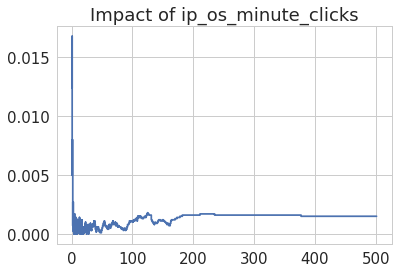

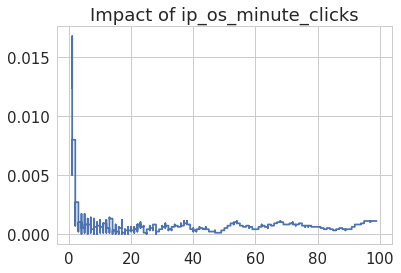

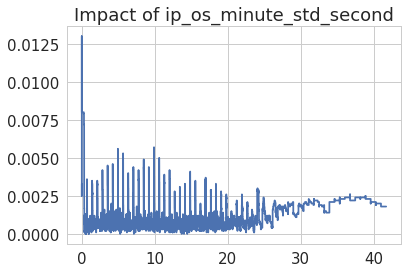

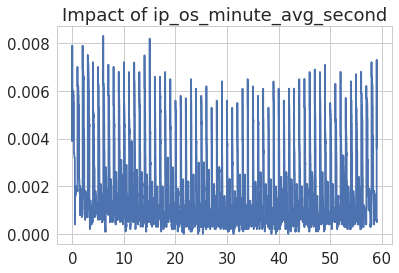

In [26]:
for f in features:
    PDF = train_sample.select('is_attributed', f).toPandas()
    PDF_sorted = PDF.sort_values(by=f)
    PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()
    plt.title('Impact of '+f)
    plt.plot(PDF_sorted[f], PDF_sorted.roll)
    plt.show()
    
    if np.max(PDF_sorted[f])>200:
        PDF_filtered = PDF_sorted[PDF_sorted[f]<100]
        plt.title('Impact of '+f)
        plt.plot(PDF_filtered[f], PDF_filtered.roll)
        plt.show()